In [1]:
import pandas as pd
import numpy as np

import os, sys
import pickle, functools, operator
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import datetime

In [2]:
training_df = pd.read_csv(os.getcwd() + "\\captions_lists\\training_list.csv")
val_df = pd.read_csv(os.getcwd() + "\\captions_lists\\validation_list.csv")

In [3]:
training_list = training_df.values.tolist()
validation_list = val_df.values.tolist()

In [5]:
vocab_list = []
for train in training_list:
    vocab_list.append(train[0])

In [6]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(vocab_list)

In [7]:
time_steps_encoder=80
num_encoder_tokens=1536
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=500
batch_size=160

encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 1536)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 500)]    0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    4196352     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

In [8]:
os.getcwd() + '\\features_resnet'

'C:\\Users\\sunja\\Documents\\videos\\features_resnet'

In [9]:
x_data = {}
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(os.getcwd() + '\\features_resnet'):
    f = np.load(os.getcwd() + '\\features_resnet\\' + filename)
    x_data[int(filename[:-4])] = f

In [11]:
train = load_datatest(batch_size=160, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(batch_size=160, training_list=validation_list, x_data=x_data, epochs=150)
time_steps_encoder=80
num_encoder_tokens=1536

latent_dim=512
time_steps_decoder=10

num_decoder_tokens=500
batch_size= 320

In [12]:
#encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)




In [13]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 1536)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 500)]    0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    4196352     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                            

In [15]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = tf.keras.optimizers.Adam(lr = 0.0003)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

C:\Users\sunja\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=150, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

<ipython-input-10-d5f323864267>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_sequences = np.array(train_sequences)


Epoch 1/150
44/44 [==============================] - 271s 6s/step - loss: 4.9572 - accuracy: 0.1421 - val_loss: 4.5866 - val_accuracy: 0.1522 - lr: 3.0000e-04
Epoch 2/150
44/44 [==============================] - 299s 7s/step - loss: 4.5565 - accuracy: 0.1604 - val_loss: 4.5060 - val_accuracy: 0.1670 - lr: 3.0000e-04
Epoch 3/150
44/44 [==============================] - 263s 6s/step - loss: 4.5034 - accuracy: 0.1696 - val_loss: 4.4638 - val_accuracy: 0.1740 - lr: 3.0000e-04
Epoch 4/150
44/44 [==============================] - 280s 6s/step - loss: 4.4538 - accuracy: 0.1777 - val_loss: 4.4033 - val_accuracy: 0.1782 - lr: 3.0000e-04
Epoch 5/150
44/44 [==============================] - 275s 6s/step - loss: 4.3979 - accuracy: 0.1901 - val_loss: 4.3355 - val_accuracy: 0.1936 - lr: 3.0000e-04
Epoch 6/150
44/44 [==============================] - 273s 6s/step - loss: 4.3324 - accuracy: 0.2009 - val_loss: 4.2762 - val_accuracy: 0.2098 - lr: 3.0000e-04
Epoch 7/150
44/44 [===========================

44/44 [==============================] - 130s 3s/step - loss: 3.1969 - accuracy: 0.3328 - lr: 3.0000e-04
Epoch 38/150
44/44 [==============================] - 115s 3s/step - loss: 3.1850 - accuracy: 0.3298 - lr: 3.0000e-04
Epoch 39/150
44/44 [==============================] - 116s 3s/step - loss: 3.1754 - accuracy: 0.3345 - lr: 3.0000e-04
Epoch 40/150
44/44 [==============================] - 110s 3s/step - loss: 3.1623 - accuracy: 0.3322 - lr: 3.0000e-04
Epoch 41/150
44/44 [==============================] - 106s 2s/step - loss: 3.1608 - accuracy: 0.3350 - lr: 3.0000e-04
Epoch 42/150
44/44 [==============================] - 105s 2s/step - loss: 3.1407 - accuracy: 0.3356 - lr: 3.0000e-04
Epoch 43/150
44/44 [==============================] - 131s 3s/step - loss: 3.1400 - accuracy: 0.3359 - lr: 3.0000e-04
Epoch 44/150
44/44 [==============================] - 141s 3s/step - loss: 3.1214 - accuracy: 0.3383 - lr: 3.0000e-04
Epoch 45/150
44/44 [==============================] - 177s 4s/step - 

Epoch 55/150
44/44 [==============================] - 114s 3s/step - loss: 3.0328 - accuracy: 0.3482 - lr: 3.0000e-04
Epoch 56/150
44/44 [==============================] - 113s 3s/step - loss: 3.0328 - accuracy: 0.3451 - lr: 3.0000e-04
Epoch 57/150
44/44 [==============================] - 106s 2s/step - loss: 3.0190 - accuracy: 0.3487 - lr: 3.0000e-04
Epoch 58/150
44/44 [==============================] - 113s 3s/step - loss: 3.0197 - accuracy: 0.3464 - lr: 3.0000e-04
Epoch 59/150
44/44 [==============================] - 113s 3s/step - loss: 3.0034 - accuracy: 0.3504 - lr: 3.0000e-04
Epoch 60/150
44/44 [==============================] - 115s 3s/step - loss: 3.0054 - accuracy: 0.3479 - lr: 3.0000e-04
Epoch 61/150
44/44 [==============================] - 113s 3s/step - loss: 2.9894 - accuracy: 0.3511 - lr: 3.0000e-04
Epoch 62/150
44/44 [==============================] - 114s 3s/step - loss: 2.9936 - accuracy: 0.3485 - lr: 3.0000e-04
Epoch 63/150
44/44 [==============================] - 11

44/44 [==============================] - 115s 3s/step - loss: 2.9268 - accuracy: 0.3559 - lr: 3.0000e-04
Epoch 73/150
44/44 [==============================] - 112s 3s/step - loss: 2.9134 - accuracy: 0.3597 - lr: 3.0000e-04
Epoch 74/150
44/44 [==============================] - 116s 3s/step - loss: 2.9161 - accuracy: 0.3571 - lr: 3.0000e-04
Epoch 75/150
44/44 [==============================] - 112s 3s/step - loss: 2.9015 - accuracy: 0.3609 - lr: 3.0000e-04
Epoch 76/150
44/44 [==============================] - 115s 3s/step - loss: 2.9072 - accuracy: 0.3590 - lr: 3.0000e-04
Epoch 77/150
44/44 [==============================] - 113s 3s/step - loss: 2.8833 - accuracy: 0.3618 - lr: 3.0000e-04
Epoch 78/150
44/44 [==============================] - 117s 3s/step - loss: 2.9011 - accuracy: 0.3601 - lr: 3.0000e-04
Epoch 79/150
44/44 [==============================] - 112s 3s/step - loss: 2.8696 - accuracy: 0.3644 - lr: 3.0000e-04
Epoch 80/150
44/44 [==============================] - 114s 3s/step - 

Epoch 90/150
44/44 [==============================] - 111s 3s/step - loss: 2.8171 - accuracy: 0.3708 - lr: 3.0000e-04
Epoch 91/150
44/44 [==============================] - 111s 3s/step - loss: 2.8132 - accuracy: 0.3708 - lr: 3.0000e-04
Epoch 92/150
44/44 [==============================] - 108s 2s/step - loss: 2.8057 - accuracy: 0.3719 - lr: 3.0000e-04
Epoch 93/150
44/44 [==============================] - 112s 3s/step - loss: 2.7986 - accuracy: 0.3732 - lr: 3.0000e-04
Epoch 94/150
44/44 [==============================] - 146s 3s/step - loss: 2.7962 - accuracy: 0.3739 - lr: 3.0000e-04
Epoch 95/150
22/44 [==============>...............] - ETA: 1:15 - loss: 2.7889 - accuracy: 0.3746
W: interrupt received, stopping


In [17]:
model.save(os.getcwd() + '\\model\\inceptionresnetv2.h5')

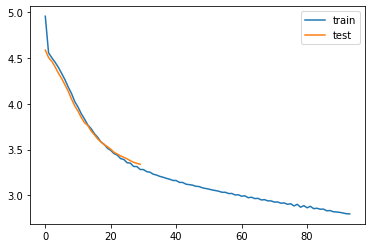

In [18]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss_inceptionresnetv2.png')
plt.show()

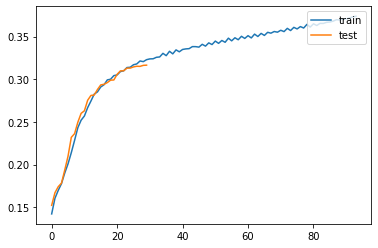

In [19]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy_inceptionresnetv2.png')
plt.show()

In [ ]:
# Saving encoder 
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
encoder_model.save(os.getcwd() + '\\model\\inception_resnet\\encoder_model_inceptionresnetv2.h5')
decoder_model.save_weights(os.getcwd() + '\\model\\inception_resnet\\decoder_model_weights_inceptionresnetv2.h5')

In [20]:
with open(os.getcwd() + '\\model\\inception_resnet' + '\\tokenizer_inceptionresnetv2','wb') as file:
    joblib.dump(tokenizer, file)
    
plot_model(encoder_model, to_file='model_inference_encoder_inceptionresnet.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder_inceptionresnet.png', show_shapes=True, show_layer_names=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 80, 1536)]       0         
                                                                 
 endcoder_lstm (LSTM)        [(None, 80, 512),         4196352   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 4,196,352
Trainable params: 4,196,352
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 10, 500)]    0           []                               